## **Leveraging Clustering and Vector Selection for Cost-Effective LLM Summarisation Tasks**


---



## Problem
The issue at hand is the limitation of context window length in Large Language Models (LLMs). Each LLM is restricted by a predetermined context length, meaning prompts must stay within this limit. Additionally, the use of longer contexts incurs greater cost.

Let us understand with an example

Let's say you are tasked with a summarisation task. It can be summarising a book, a long research paper or maybe a bunch of reviews. In this example we are considering a use case where we are summarising reviews of a movie called Interstellar (one of my all time favourites). This summarised review should fully encompass what is said in all reviews.

## Setup
I have prepared this [JSON file](https://gist.github.com/iamvishalkhare/68a8a5ab47d6cf48d49429f141935531) (w/ help from ChatGPT) which contains 206 reviews of Interstellar. To help readers understand the structure of JSON, Here is how the file looks like-
```
{
    "reviews": [
        {
            "reviewer": "CinephileChris",
            "review": "Interstellar is a visual tour de force that takes audiences on an emotional rollercoaster through space and time. The stunning effects and powerful performances create a captivating experience that lingers with you long after the credits roll."
        },
        {
            "reviewer": "FilmFanatic123",
            "review": "Christopher Nolan's Interstellar is a mind-bending journey that seamlessly blends cutting-edge science with heart-wrenching human drama. The film's ambitious scope and intricate plot keep you guessing until the very end, making it a must-see for sci-fi enthusiasts."
        },
        {
            "reviewer": "PopcornPete",
            "review": "Interstellar is a visual spectacle that pushes the boundaries of what science fiction can achieve on the big screen. While some may find its complexities a bit daunting, the film rewards viewers with a deeply thought-provoking story and breathtaking visuals."
        }
    ]
}
```

Let's load up the JSON file and see how many tokens are we talking about when we want to summarise all reviews



In [61]:
!pip install langchain jq openai tiktoken numpy

In [62]:
from langchain import OpenAI
from google.colab import userdata
llm = OpenAI(temperature=0, openai_api_key=userdata.get('OPENAI_KEY'))

In [63]:
from langchain_community.document_loaders import JSONLoader
loader=JSONLoader(file_path="movie_review.json",jq_schema=".reviews[].review", text_content=False)
docs=loader.load()
text = ""
for doc in docs:
    text += doc.page_content

In [64]:
print(llm.get_num_tokens(text))

10329


That's a whopping ~10K tokens. First of all I won't be able to fit 10K tokens in GPT-4 8K context window models (e.g. gpt-4 and gpt-4-0314)
Secondly, it would cost us $0.60 for GPT-4 32K context window models (e.g. gpt-4-32k and gpt-4-32k-0314). This is just for prompt tokens. We not even talking about sampled tokens yet.

You could imagine how expensive it can get when summarising long texts. Given this situation, summarising extended documents like books or research papers, which may exceed 100K tokens, could become prohibitively costly.

## Solution
Without much deliberation, we can assume that if there is a way which can skip a few tokens and yet represent a wholistic but diverse view of all reviews can be helpful

**Objective**: Get vector embeddings of each review. Pick a subset of vectors which represent a wholistic but diverse view of all reviews. In other words, is there a way to pick the top 10 reviews that describe all reviews the best?

Once we have a subset of vectors which represent all reviews we can then summarise all those vectors to get a pretty good summary of all reviews.

Keep in mind that this is not a deterministic but a probabilistic solution. There can still be some information loss but then that's the essence of summarisation - You loose some information.

We can follow this simple algorithm. Let's call it **Centroid based vector selection (CBVS).** Here are steps of this algorithm-



1.   **Embedding**- Embed each review to get vectors.
2.   **Clustering**- Cluster the vectors to see which are similar to each other These are the reviews that likely are similar.
3.   **Vector selection** - Pick embeddings that represent the cluster the most (method: closest to each cluster centroid)
4.   **Summarising selected docs**- Summarise the documents that these embeddings represent. You will end up with a subset of summarised reviews.
5.   **Summarisation of summaries** - Create a summary of summaries to get a final summary.








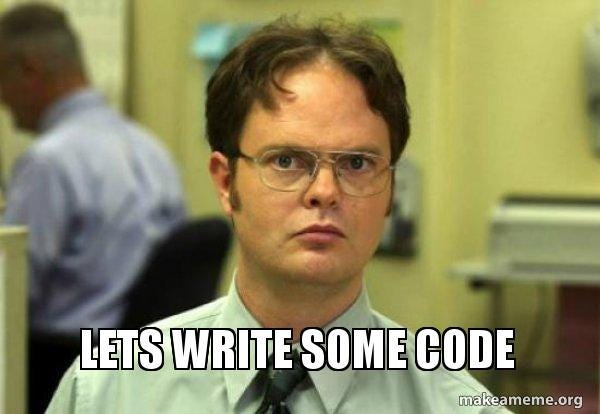

### 1. Embedding - Embed each review to get vectors.
We will be using `OpenAIEmbeddingsof` langchain. This will use OpenAI's `text-embedding-ada-002` model to create embeddings with 1536 dimensions.

In [65]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(openai_api_key=userdata.get('OPENAI_KEY'))

vectors = embeddings.embed_documents([x.page_content for x in docs])

### 2. Clustering - Cluster the vectors to see which are similar to each other. These are the reviews that likely are similar.
Now let's cluster our embeddings. There are a ton of clustering algorithms you can chose from. Please try a few out to see what works best for you!

In [66]:
from langchain.chat_models import ChatOpenAI

import numpy as np
from sklearn.cluster import KMeans

In [67]:
num_clusters = 8

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [68]:
kmeans.labels_

array([0, 5, 4, 5, 5, 4, 3, 5, 0, 5, 3, 7, 5, 5, 5, 1, 2, 5, 1, 5, 0, 0,
       0, 0, 5, 0, 0, 0, 7, 1, 0, 0, 2, 0, 5, 2, 0, 1, 0, 2, 6, 3, 3, 0,
       4, 3, 3, 4, 2, 3, 4, 2, 6, 5, 0, 7, 6, 4, 4, 2, 7, 3, 4, 4, 6, 4,
       2, 6, 4, 2, 3, 4, 4, 6, 4, 2, 6, 4, 2, 6, 4, 4, 6, 4, 2, 6, 4, 2,
       7, 5, 0, 0, 5, 0, 7, 1, 7, 0, 4, 2, 3, 1, 7, 7, 0, 3, 7, 1, 0, 3,
       7, 4, 1, 7, 3, 2, 7, 0, 1, 2, 0, 1, 0, 7, 4, 2, 7, 7, 2, 0, 0, 3,
       7, 4, 1, 7, 3, 2, 7, 0, 1, 2, 0, 1, 0, 7, 4, 1, 2, 6, 0, 1, 5, 0,
       0, 5, 3, 1, 7, 4, 1, 4, 1, 7, 2, 7, 1, 4, 1, 2, 1, 7, 1, 7, 7, 1,
       7, 1, 2, 1, 4, 7, 7, 1, 7, 1, 7, 7, 1, 4, 1, 7, 7, 7, 1, 7, 1, 7,
       1, 7, 1, 1, 1, 1, 1, 1], dtype=int32)

In [69]:
arr = kmeans.labels_
unique, counts = np.unique(arr, return_counts=True)
distribution = dict(zip(unique, counts))
print(distribution)

{0: 33, 1: 38, 2: 24, 3: 16, 4: 29, 5: 17, 6: 11, 7: 38}


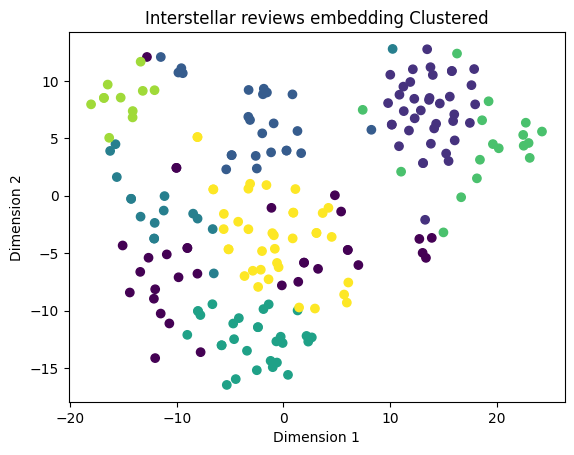

In [70]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vectors = np.array(vectors)
# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(vectors)

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Interstellar reviews embedding Clustered')
plt.show()

### 3. Vector selection - Pick embeddings that represent the cluster the most (method: closest to each cluster centroid)
We will pick the embedding closest to the centroid of the cluster because I assume that would represent the most average meaning of that cluster. Based on your use case you can tweak which embeddings from the cluster you want to pick.

In [71]:
# Find the closest embeddings to the centroids
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

### 4. Summarising selected docs - Summarise the documents that these embeddings represent. You will end up with a subset of summarised reviews.
I'm going to initialize two models, gpt-3.5 and gpt4. I'll use gpt 3.5 for the first set of summaries to reduce cost and then gpt4 for the final pass which should increase the quality.

In [72]:
llm3 = ChatOpenAI(temperature=0,
                 openai_api_key=userdata.get('OPENAI_KEY'),
                 max_tokens=1000,
                 model='gpt-3.5-turbo'
                )

In [73]:
from langchain import PromptTemplate

map_prompt = """
You will be given a single review of a movie. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this review so that a reader will have a full understanding of what is the review talking about
Your response should be at least 50 words and fully encompass what was said in the passage.


```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [74]:
from langchain.chains.summarize import load_summarize_chain

map_chain = load_summarize_chain(llm=llm3,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [75]:
closest_docs = [docs[doc] for doc in closest_indices]

In [76]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the length of your selected docs
for i, doc in enumerate(closest_docs):

    # Go get a summary of the review
    chunk_summary = map_chain.run([doc])

    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{closest_indices[i]}) - Preview: {chunk_summary[:250]} \n")

Summary #0 (chunk #108) - Preview: The review of "Interstellar" praises the movie for its captivating journey through time and space, stunning visuals, and emotionally resonant storytelling. It highlights the film's exploration of scientific concepts and existential themes, which elev 

Summary #1 (chunk #202) - Preview: The review praises "Interstellar" as a visually stunning and emotionally gripping sci-fi epic that takes audiences on a breathtaking journey through space and time. It highlights Christopher Nolan's visionary direction, stellar performances, and the  

Summary #2 (chunk #137) - Preview: The review describes "Interstellar" as an ambitious and visually stunning film that takes viewers on a journey through space and time. It explores themes of love, sacrifice, and the resilience of the human spirit. The emotional resonance and stunning 

Summary #3 (chunk #114) - Preview: The review of "Interstellar" praises the movie for its captivating mix of science fiction elements an

### 5. Summarisation of summaries - Create a summary of summaries to get a final summary.
Let's now create a final summary of summaries

In [77]:
from langchain.schema import Document

summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 578 tokens


In [78]:
llm4 = ChatOpenAI(temperature=0,
                 openai_api_key=userdata.get('OPENAI_KEY'),
                 max_tokens=3000,
                 model='gpt-4',
                 request_timeout=120
                )

In [79]:
combine_prompt = """
You will be given a series of summaries of a movie. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of all reviews.
The reader should be able to grasp all intricacies of reviews and the summary should be representative of wholistic but diverse view of all reviews.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [80]:
reduce_chain = load_summarize_chain(llm=llm4,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
                              verbose=True # Set this to true if you want to see the inner workings
                                   )

In [81]:
output = reduce_chain.run([summaries])



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

You will be given a series of summaries of a movie. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of all reviews.
The reader should be able to grasp all intricacies of reviews and the summary should be representative of wholistic but diverse view of all reviews.

```The review of "Interstellar" praises the movie for its captivating journey through time and space, stunning visuals, and emotionally resonant storytelling. It highlights the film's exploration of scientific concepts and existential themes, which elevate it to a thought-provoking meditation on the nature of the cosmos and the human experience. Overall, the reviewer found "Interstellar" to be a mesmerizing and thought-provoking cinematic experience.
The review praises "Interstellar" as a visually stunning and emotionally gripping sci-fi epic that takes audiences on a brea

In [82]:
print(output)

The reviews of "Interstellar" universally laud the film for its captivating and breathtaking journey through time and space, with many highlighting its stunning visuals and emotionally resonant storytelling. The film's exploration of scientific concepts and existential themes is frequently mentioned, with reviewers noting that these elements elevate the movie to a thought-provoking meditation on the nature of the cosmos and the human experience. 

Christopher Nolan's visionary direction is praised, as are the stellar performances from the cast, with Anne Hathaway's transformative acting receiving particular mention. The film's exploration of themes such as love, sacrifice, and the unknown is seen as deeply moving and resonant on a profound level. The resilience of the human spirit is another theme that reviewers found compelling. 

The film's ability to engage viewers in contemplating the mysteries of the universe and the human spirit is commended, with reviewers noting that this makes

## Conclusion





1.   Looking at the final summary generated, It seems pretty good.
2.   Cost should be reduced by the factor of number of clusters. Approximately by factor of 11 in this case.
3.   This algorithm/technique can used to summarise books, scripts, research papers and lot more.
4.    There is some loss of information but then show me a summary which doesn't loose any information.
5.    Choosing closest vector from centroid of the cluster was a personal choice. You can choose different vectors depending on your specific use case.


